#  Imports

In [1]:
# %load_ext autoreload
# %autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [2]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import albumentations.pytorch as albu_pt
%matplotlib inline

import apex
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import pytorch_tools as pt

from src.dataset import OpenCitiesDataset, OpenCitiesTestDataset, InriaTilesDataset
from src.augmentations import get_aug
from src.callbacks import ThrJaccardScore
from pytorch_tools.fit_wrapper.callbacks import SegmCutmix

In [3]:
import yaml
from src.utils import MODEL_FROM_NAME
from pytorch_tools.fit_wrapper.callbacks import Callback
from pytorch_tools.utils.misc import to_numpy

# Get dataloaders

In [4]:
SZ = 384
BS = 16
BUILDINGS_ONLY = False
RETURN_DISTANCE = False
# RETURN_DISTANCE = True

aug = get_aug("medium", SZ)

val_aug = get_aug("val", SZ)

test_aug = get_aug("test", SZ)

val_dtst = OpenCitiesDataset(split="val", transform=val_aug, buildings_only=BUILDINGS_ONLY, return_distance=RETURN_DISTANCE)
val_dtld = DataLoader(val_dtst, batch_size=BS, shuffle=False, num_workers=4, drop_last=True)
val_dtld_i = iter(val_dtld)

train_dtst = OpenCitiesDataset(split="train", transform=aug, buildings_only=BUILDINGS_ONLY, return_distance=RETURN_DISTANCE)
train_dtld = DataLoader(train_dtst, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)
train_dtld_i = iter(train_dtld)

test_dtst = OpenCitiesTestDataset(transform=test_aug)
test_dtld = DataLoader(test_dtst, batch_size=BS, shuffle=False, num_workers=8, drop_last=False)
test_dtld_i = iter(test_dtld)

In [5]:
val_dtst_inria = InriaTilesDataset(split="val", transform=val_aug)
val_dtst_inria = val_dtst_inria + val_dtst
val_dtld_inria = DataLoader(val_dtst_inria, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)

train_dtst_inria = InriaTilesDataset(split="train", transform=aug)
train_dtld_inria = DataLoader(train_dtst_inria, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)

In [6]:
class ToCudaLoader:
    def __init__(self, loader):
        self.loader = loader
        
    def __iter__(self):
        return ((img.cuda(), target.cuda()) for img, target in self.loader)
    
    def __len__(self):
        return len(self.loader)
    
val_dtld_gpu = ToCudaLoader(val_dtld)
train_dtld_gpu = ToCudaLoader(train_dtld)
val_dtld_inria_gpu = ToCudaLoader(val_dtld_inria)
train_dtld_inria_gpu = ToCudaLoader(train_dtld_inria)

In [7]:
len(train_dtst), len(val_dtst), len(test_dtst)

(25281, 4381, 11481)

In [8]:
len(train_dtst_inria), len(val_dtst_inria)

(26195, 5606)

In [9]:
img, mask = train_dtst[1]
img.shape, mask.shape

(torch.Size([3, 384, 384]), torch.Size([3, 384, 384]))

In [10]:
img, mask = train_dtst_inria[1]
img.shape, mask.shape

(torch.Size([3, 384, 384]), torch.Size([1, 384, 384]))

In [11]:
# plt.imshow(mask[2])

In [12]:
test_dtst[0][0].shape, test_dtst[0][1].shape

((1024, 1024, 3), torch.Size([3, 1024, 1024]))

In [13]:
val_dtld_i = iter(val_dtld)
# val_dtld_i = iter(train_dtld)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


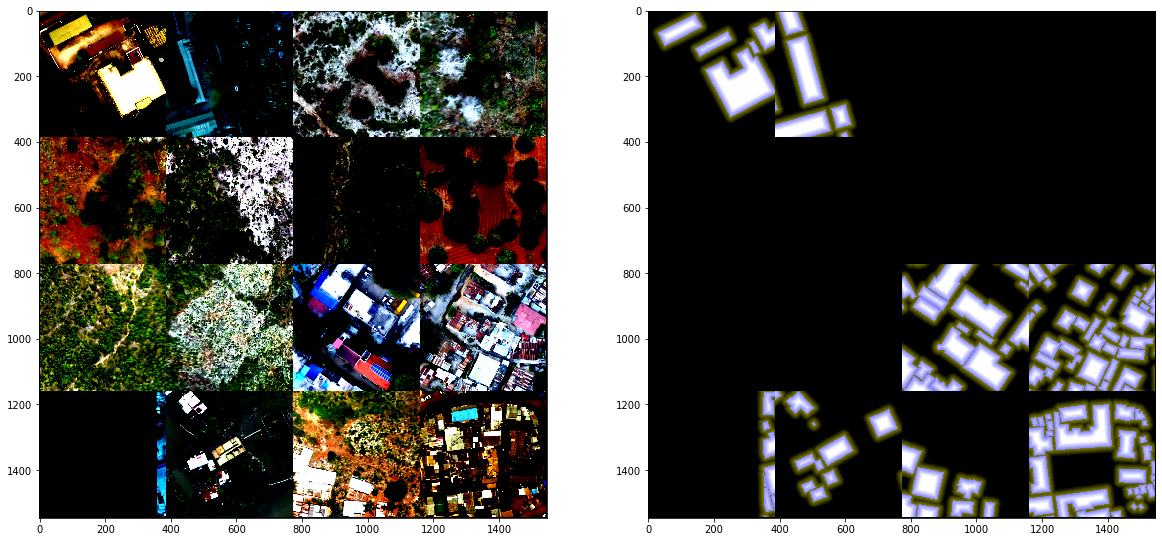

In [44]:
# batch = next(val_dtld_i)
imgs, masks = next(val_dtld_i)
# imgs_c = imgs
# imgs = imgs_c
# imgs, masks = SegmCutmix(1, 1).cutmix(imgs, masks) # test cutmix
# (_, imgs, _), (_, masks, _) = next(test_dtld_i), next(test_dtld_i) 
# preds = torch.nn.MSELoss(reduction='none')(preds, masks)
preds = model(imgs.cuda()).cpu().detach()
# imgs = (preds > 0).float()
# imgs = preds.clamp(-1, 1)#.sigmoid()
imgs_grid = make_grid(imgs, nrow=4).transpose(0,2)#.transpose(0,1)
masks_grid = make_grid(masks, nrow=4).transpose(0,2)#.transpose(0,1)
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(imgs_grid)
axes[1].imshow(masks_grid);

In [45]:
from src.utils import criterion_from_list

In [46]:
l = criterion_from_list(["mse", 1.])

In [47]:
l(preds, masks)

tensor(16.8677)

In [48]:
pt.losses.MSELoss()(preds, masks[:, 0:1, :, :])

tensor(16.8677)

# Model training

In [18]:
# from bloodaxe_models import get_model as get_ba_model

In [19]:
# model = pt.segmentation_models.DeepLabV3('se_resnet50', output_stride=16, num_classes=1).cuda()
model = pt.segmentation_models.Unet('se_resnet50', num_classes=1).cuda()
# model = get_ba_model("hrnet34_unet64").cuda()
# model = get_ba_model("resnet34_fpncat128").cuda()
# model = pt.segmentation_models.SegmentationFPN('se_resnet50', num_classes=1, merge_policy="cat").cuda()
# model = pt.segmentation_models.SegmentationBiFPN('se_resnet50', num_fpn_layers=1, merge_policy="cat").cuda()
# optim = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
optim = apex.optimizers.FusedNovoGrad(model.parameters(), weight_decay=1e-4, set_grad_none=False)
model, optim = apex.amp.initialize(model, optim, verbosity=0, loss_scale=2048)
# freeze encoder
# for p in model.encoder.parameters():
#     p.requires_grad = False
pt.utils.misc.count_parameters(model)

(35051968, 35051968)

In [20]:
# log_path = "logs/2.deeplab_nov_warmup_20200212_171523/"
# model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)

In [51]:
class ThrMSELoss(torch.nn.MSELoss):
    def forward(self, input, target):
        input = torch.clamp(input, -1, 1)
        return torch.nn.functional.mse_loss(input, target, reduction=self.reduction)

In [53]:
# loss = pt.losses.CrossEntropyLoss(mode="binary").cuda()
# loss = pt.losses.DiceLoss(mode="binary").cuda()
# loss = 0.5 * pt.losses.CrossEntropyLoss(mode="binary").cuda() + 0.5 * loss
# loss = 0.5 * loss + 0.5 * pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.LovaszLoss().cuda() + 4 * pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.BinaryHinge().cuda()
# loss = ThrMSELoss() #torch.nn.MSELoss()
loss = torch.nn.L1Loss()

In [54]:
bce_metric = pt.losses.CrossEntropyLoss(mode="binary").cuda()
bce_metric.name = "BCE"

In [55]:
runner = pt.fit_wrapper.Runner(
    model, 
    optim, 
    criterion=loss, # pt.losses.BinaryHinge(), 
    callbacks=[
#         pt.fit_wrapper.callbacks.Timer(),
        pt.fit_wrapper.callbacks.ConsoleLogger(), 
        pt.fit_wrapper.callbacks.SegmCutmix(),
#         PatchTarget(), # needed for bloodaxe models
#         pt.fit_wrapper.callbacks.ReduceLROnPlateau(10),
#         pt.fit_wrapper.callbacks.FileLogger('/tmp/')
    ],
    metrics=[pt.metrics.JaccardScore(mode="binary"), bce_metric, ThrJaccardScore(thr=0.5)],
)

In [25]:
# freeze encoder
for p in model.encoder.parameters():
    p.requires_grad = False

In [26]:
# imgs, masks = next(iter(val_dtld_gpu))
# pred = model(imgs)
# imgs.dtype, masks.dtype, imgs.shape, masks.shape, pred.shape

In [27]:
runner.fit(train_dtld_gpu, val_loader=val_dtld_gpu, epochs=10) #, val_loader=val_dtld_inria_gpu, epochs=1)

Epoch  1/10. training: 1581it [03:06,  8.50it/s, BCE=6.328, Jaccard=1.051, Loss=1.2607, ThrJaccard@0.5=-0.053]               
Epoch  1/10. validating: 274it [00:19, 13.93it/s, BCE=2.884, Jaccard=0.657, Loss=0.2974, ThrJaccard@0.5=-0.002]             
Epoch  2/10. training: 1581it [03:03,  8.60it/s, BCE=1.181, Jaccard=0.651, Loss=0.2485, ThrJaccard@0.5=-0.013]              
Epoch  2/10. validating: 274it [00:19, 13.98it/s, BCE=1.900, Jaccard=0.717, Loss=0.1965, ThrJaccard@0.5=-0.036]             
Epoch  3/10. training: 1581it [03:30,  7.50it/s, BCE=0.684, Jaccard=0.721, Loss=0.1941, ThrJaccard@0.5=-0.023]              
Epoch  3/10. validating: 274it [00:22, 12.17it/s, BCE=0.976, Jaccard=0.768, Loss=0.1501, ThrJaccard@0.5=-0.039]             
Epoch  4/10. training: 1581it [03:18,  7.96it/s, BCE=0.276, Jaccard=0.685, Loss=0.1592, ThrJaccard@0.5=-0.025]               
Epoch  4/10. validating: 274it [00:20, 13.67it/s, BCE=0.413, Jaccard=0.553, Loss=0.1178, ThrJaccard@0.5=-0.040]            

torch.Size([16, 1, 384, 384])

In [56]:
for p in model.parameters():
    p.requires_grad = True

In [57]:
runner.fit(train_dtld_gpu, val_loader=val_dtld_gpu, epochs=5)

Epoch  1/5. training: 1581it [04:33,  5.78it/s, BCE=-0.480, Jaccard=0.703, Loss=0.1524, ThrJaccard@0.5=-0.049]              
Epoch  1/5. validating: 274it [00:19, 14.27it/s, BCE=-0.449, Jaccard=0.661, Loss=0.0942, ThrJaccard@0.5=-0.059]             
Epoch  2/5. training:  48% 762/1580 [02:12<02:20,  5.81it/s, BCE=-0.438, Jaccard=0.751, Loss=0.1041, ThrJaccard@0.5=-0.056]

KeyboardInterrupt: 

# Results examination

In [11]:
# log_path = "logs/fpn_sm_cat_seresnet50_20200208_190143/"
# log_path = "logs/fpn_sm_20200205_165954/" # 0.71 on LB. 0.67 on local per image
# log_path = "logs/deeplab_small_dilation_seresnet50_20200209_112059/" # 0.72 on local val
# log_path = "logs/fpn_nov_bce_dice_seresnet50_20200209_235106/"
# log_path = "logs/3.segm_fpn_nov_hinge_seresnet50_warmup_20200213_160637/"
log_path = "logs/4.baseline_deeplab_nov_cutmix_20200220_192427/"
config = yaml.load(open(log_path + "config.yaml"))
model = MODEL_FROM_NAME[config["segm_arch"]](config["arch"], **config.get("model_params", {})).cuda()
print("model loaded")
model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)

model loaded


<All keys matched successfully>

In [12]:
# torch.onnx.export(model, torch.ones(1, 3, 256, 256).cuda(), "model.onnx")

In [13]:
model = apex.amp.initialize(model, verbosity=0)

In [14]:
val_dtld = DataLoader(val_dtst, batch_size=1, shuffle=False, num_workers=2, drop_last=True)
val_dtld_gpu = ToCudaLoader(val_dtld)

In [15]:
# val_dtld = DataLoader(val_dtst, batch_size=16, shuffle=False, num_workers=4, drop_last=True)
# val_dtld_gpu = ToCudaLoader(val_dtld)

In [16]:
class ResultsHist(Callback):
    """Saves all values of loss"""
    def __init__(self):
        super().__init__()
        self.res = []
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        loss = self.state.metrics[0](output, target)
        self.res.append(to_numpy(loss))
    
    def on_loader_end(self):
        self.res = np.array(self.res)
        
class PredSaver(Callback):
    """Saves best and worse predicts"""
    def __init__(self, best_thr=0.9, worst_thr=0.2, filter_empty=True):
        super().__init__()
        self.best_img = []
        self.best_target = []
        self.best_preds = []
        self.best_metric = []
        
        self.worst_img = []
        self.worst_target = []
        self.worst_preds = []
        self.worst_metric = []
        
        self.best_thr = best_thr
        self.worst_thr = worst_thr
        self.filter_empty = filter_empty
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        metric = self.state.metrics[0](output, target)
        metric = to_numpy(metric)
        if metric > self.best_thr:
            if self.filter_empty and to_numpy(target).sum() == 0:
                return 
            self.best_img.append(to_numpy(data))
            self.best_target.append(to_numpy(target))
            self.best_preds.append(to_numpy(output))
            self.best_metric.append(metric)
        
        if metric < self.worst_thr:
            self.worst_img.append(to_numpy(data))
            self.worst_target.append(to_numpy(target))
            self.worst_preds.append(to_numpy(output))
            self.worst_metric.append(metric)
#         self.res.append(pt.utils.misc.to_numpy(metric))
    
    def on_loader_end(self):
        if len(self.worst_img) > 0:
            self.worst_img = np.swapaxes(np.array(self.worst_img).squeeze(), 1, 3)
            self.worst_img = np.swapaxes(self.worst_img, 1, 2)
            self.worst_target = np.array(self.worst_target).squeeze()
            self.worst_preds = np.array(self.worst_preds).squeeze()
            self.worst_metric = np.array(self.worst_metric)
        
        if len(self.best_img) > 0:
            self.best_img = np.swapaxes(np.array(self.best_img).squeeze(), 1, 3)
            self.best_img = np.swapaxes(self.best_img, 1, 2)
            self.best_target = np.array(self.best_target).squeeze()
            self.best_preds = np.array(self.best_preds).squeeze()
            self.best_metric = np.array(self.best_metric)
    
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

In [17]:
hinge_metric = pt.losses.BinaryHinge()
hinge_metric.name = "Hinge"

In [18]:
loss = pt.losses.JaccardLoss()
results_hist = ResultsHist()
pred_saver = PredSaver(worst_thr=0.05, best_thr=0.3)
runner = pt.fit_wrapper.Runner(
    model, 
    None, 
    criterion=loss,
    callbacks=[
        pt.fit_wrapper.callbacks.ConsoleLogger(),
        results_hist,
        pred_saver,
    ],
    metrics=[
        hinge_metric,
        ThrJaccardScore(thr=0.5),
#         hinge_metric,
#         bce_metric,
        pt.metrics.JaccardScore(mode="binary"),
        
#         ThrJaccardScore(thr=0.3),
#         ThrJaccardScore(thr=0.4),
    ]
)
runner.evaluate(val_dtld_gpu)

Epoch  1/1. validating: 4382it [02:26, 29.93it/s, Hinge=0.110, Jaccard=0.244, Loss=0.7557, ThrJaccard@0.5=0.875]              


(0.7556891007201363,
 [0.10969979208092953, 0.8750921239512229, 0.24431089927986369])

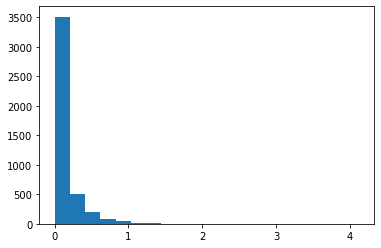

In [19]:
plt.hist(results_hist.res, bins=20);

In [20]:
len(pred_saver.worst_preds), len(pred_saver.best_preds)

(2951, 641)

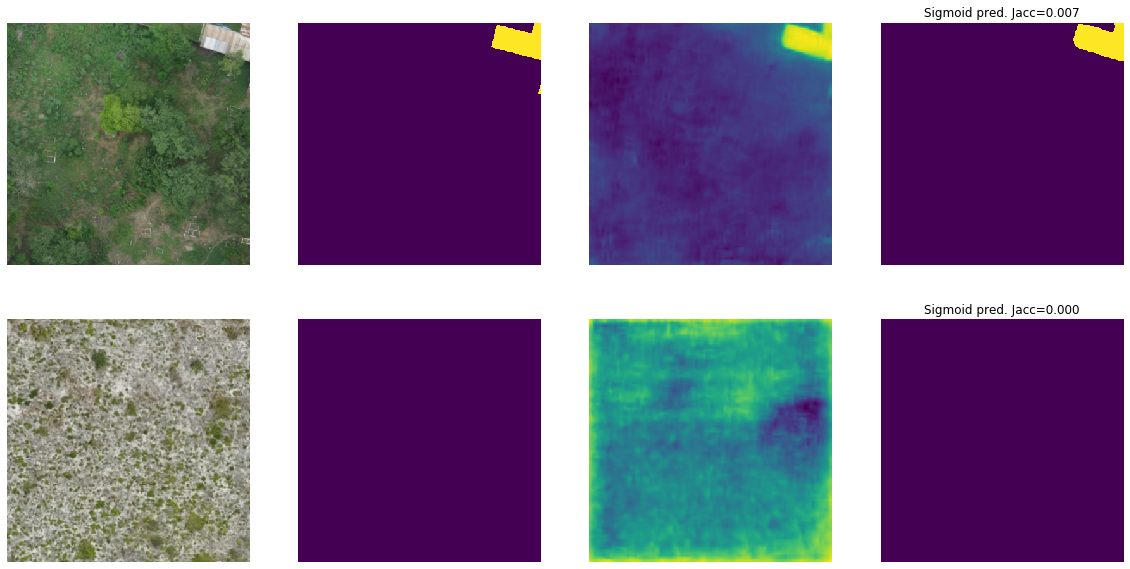

In [31]:
# Worst predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.worst_preds))
    img = pred_saver.worst_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    img = (img * 255).astype(np.uint8)
    pred = pred_saver.worst_preds[N]
    axes[i][0].imshow(img)
    axes[i][1].imshow(pred_saver.worst_target[N])
    axes[i][2].imshow(pred)
    axes[i][3].imshow(sigmoid(pred_saver.worst_preds[N]) > 0.5)
#     axes[i][3].imshow(pred_saver.worst_preds[N] > 0.5)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.worst_metric[N]:.03f}")
    

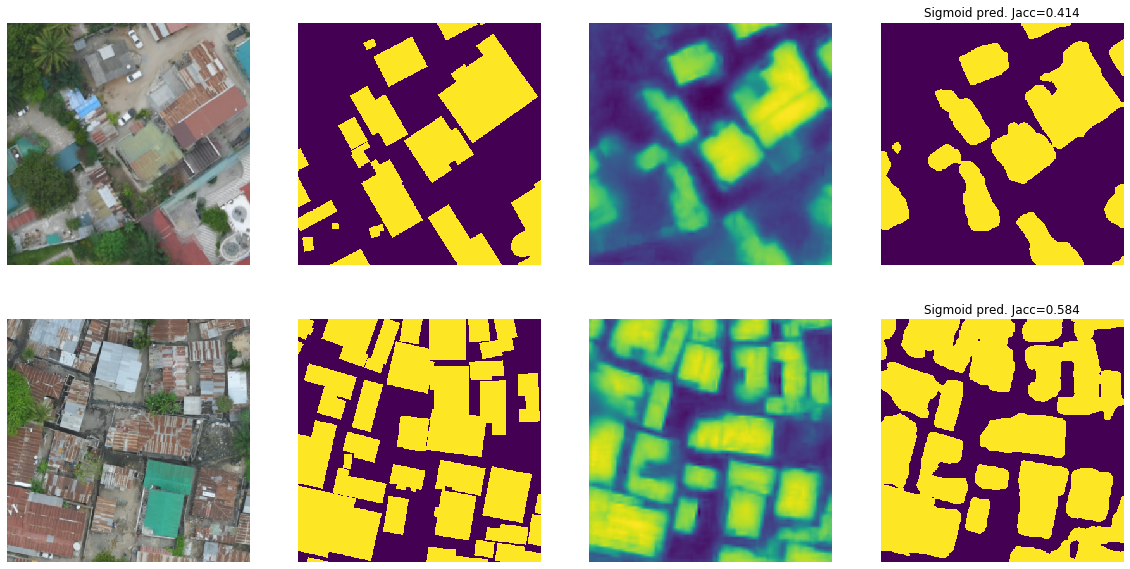

In [60]:
# Best predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.best_preds))
    img = pred_saver.best_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    img = (img * 255).astype(np.uint8)
    pred = pred_saver.best_preds[N]
    axes[i][0].imshow(img)
    axes[i][1].imshow(pred_saver.best_target[N])
    axes[i][2].imshow(pred)
    axes[i][3].imshow(sigmoid(pred_saver.best_preds[N]) > 0.5)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.best_metric[N]:.03f}")
    

# Test CRF

In [33]:
import morphsnakes as ms

In [34]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [35]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray_img)

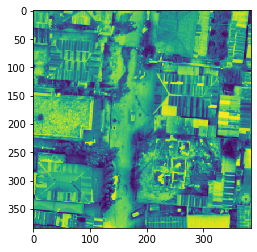

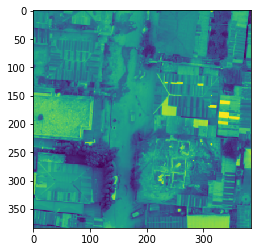

In [36]:
plt.imshow(cl1)
plt.show()
plt.imshow(gray_img)

In [37]:
gray_img.max()

252

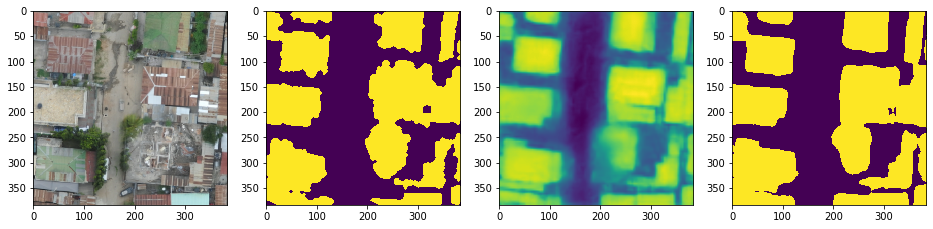

In [44]:
ac_pred = ms.morphological_chan_vese(gray_img, iterations=10, 
                                         init_level_set=pred,
#                                          init_level_set="checkerboard",
                                         smoothing=2, #threshold=0.31,
#                                          balloon=1
#                                          lambda1=0.5,
#                                          lambda2=2,
                                    )

fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
axes[0].imshow(img)
axes[1].imshow(ac_pred)
axes[2].imshow(pred)
axes[3].imshow(sigmoid(pred) > 0.5)

# Looking for bugs